<a href="https://colab.research.google.com/github/sagyn19/nes1/blob/main/NES1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your Excel file
github_url = "https://github.com/sagyn19/nes1/blob/main/fifa_players_nes1.xlsx"
url = github_url.replace("github.com", "raw.githubusercontent.com").replace("blob/", "")
df = pd.read_excel(url)  # adjust the path if needed

# Step 1: Simplify player positions
def simplify_position(pos_str):
    pos_str = pos_str.upper()
    if "GK" in pos_str:
        return "GK"
    elif any(p in pos_str for p in ["CB", "LB", "RB", "LWB", "RWB"]):
        return "D"
    elif any(p in pos_str for p in ["CM", "CDM", "CAM", "LM", "RM"]):
        return "M"
    elif any(p in pos_str for p in ["CF", "ST", "LW", "RW"]):
        return "F"
    return "Other"

df["main_position"] = df["positions"].apply(simplify_position)

# Step 2: Keep only D, M, F players
df_filtered = df[df["main_position"].isin(["D", "M", "F"])].copy()

# Step 3: Select relevant numerical features
feature_columns = [
    'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
    'dribbling', 'curve', 'freekick_accuracy', 'long_passing', 'ball_control',
    'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance',
    'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
    'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
    'composure', 'marking', 'standing_tackle', 'sliding_tackle'
]

X = df_filtered[feature_columns].values
y = df_filtered["main_position"].map({"D": 0, "M": 1, "F": 2}).values

# Step 4: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Optional: print shapes and class distribution
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("Train labels:", np.bincount(y_train))
print("Test labels:", np.bincount(y_test))



X_train: (362, 29)
X_test: (91, 29)
Train labels: [124 170  68]
Test labels: [31 43 17]


In [5]:
import matplotlib.pyplot as plt

# Plot accuracy and loss from training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4519 - loss: 1.1206 - val_accuracy: 0.6027 - val_loss: 0.8837
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6219 - loss: 0.8744 - val_accuracy: 0.6986 - val_loss: 0.7399
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7177 - loss: 0.7033 - val_accuracy: 0.7671 - val_loss: 0.6500
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7351 - loss: 0.6371 - val_accuracy: 0.7397 - val_loss: 0.6061
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7642 - loss: 0.5903 - val_accuracy: 0.7260 - val_loss: 0.5412
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8145 - loss: 0.4812 - val_accuracy: 0.7808 - val_loss: 0.4877
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7988 - loss: 0.4904 - val_accuracy: 0.8219 - val_loss: 0.4518
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8638 - loss: 0.4130 - val_accuracy: 0.8082 - val_

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

🧾 Classification report:
              precision    recall  f1-score   support

    Defender       0.94      0.94      0.94        31
  Midfielder       0.88      0.88      0.88        43
     Forward       0.82      0.82      0.82        17

    accuracy                           0.89        91
   macro avg       0.88      0.88      0.88        91
weighted avg       0.89      0.89      0.89        91



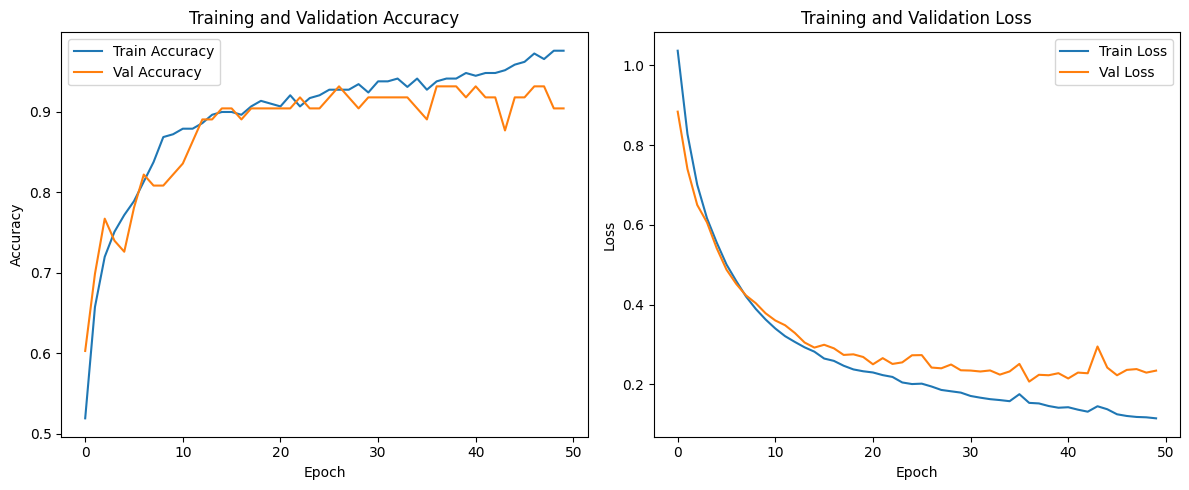

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report

# Build the model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),     # 29 features
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(3, activation='softmax')        # 3 output classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    verbose=1
)

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test accuracy: {test_acc:.2f}")

# Predict and show classification report
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

print("\n🧾 Classification report:")
print(classification_report(y_test, y_pred, target_names=["Defender", "Midfielder", "Forward"]))
plot_training_history(history)

Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.89      0.91      0.90        46
           2       0.80      0.80      0.80        20

    accuracy                           0.90        91
   macro avg       0.90      0.89      0.89        91
weighted avg       0.90      0.90      0.90        91

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7317 - loss: 11.1198 - val_accuracy: 0.8356 - val_loss: 7.4768
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7764 - loss: 10.6778 - val_accuracy: 0.8356 - val_loss: 7.4833
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8409 - loss: 4.9356 - val_accuracy: 0.8082 - val_loss: 6.7849
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8394 - loss: 4.0806 - val_accuracy: 0.8767 - val_loss: 4.4042
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8251 - loss: 4.2312 - val_accuracy: 0.7808 - val_loss: 7.8493
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8206 - loss: 5.6467 - val_accuracy: 0.8767 - val_loss: 2.6128
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8621 - loss: 3.2807 - val_accuracy: 0.8767 - val_loss: 2.7361
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8932 - loss: 2.5594 - val_accuracy: 0.9041 - val_loss: 1.9

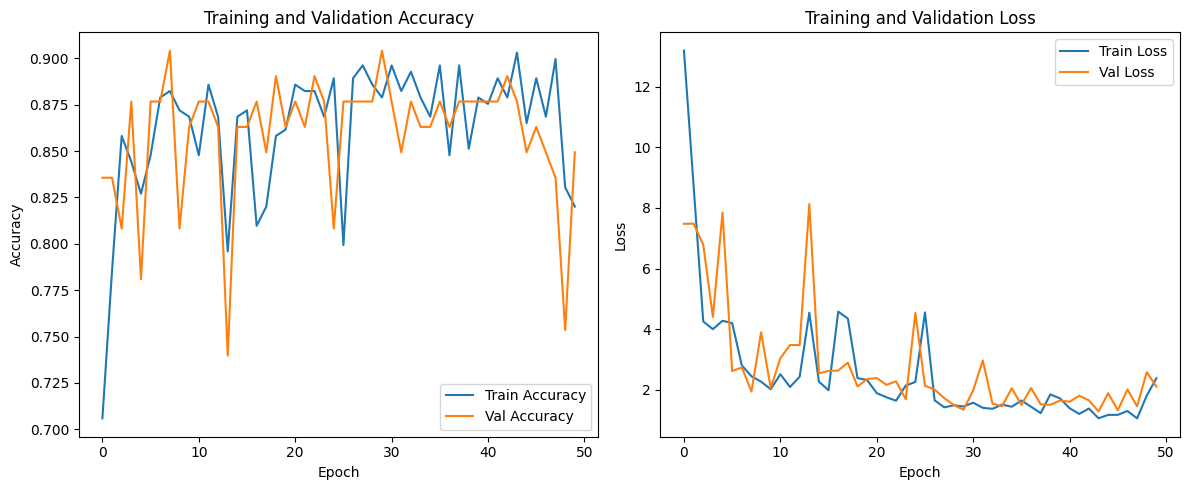

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split encoded target into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train logistic regression
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train, y_train)

# Evaluate
y_pred_log = logreg.predict(X_test)
print("Logistic Regression:\n", classification_report(
    y_test, y_pred_log,
    target_names=[str(cls) for cls in label_encoder.classes_]
))



In [10]:
import pandas as pd

# Example results
results = {
    "Model": ["Neural Network", "Logistic Regression"],
    "Accuracy": [
        model.evaluate(X_test, y_test, verbose=0)[1],
        logreg.score(X_test, y_test)
    ]
}

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy
0       Neural Network  0.802198
1  Logistic Regression  0.901099
